# ME Assignment
1. Implement the EM algorithm for clustering with multivariate Gaussian models
discussed in the LearningGM section. Initialize the algorithm with the K-means result
(for example Matlab provides a kmeans function). Assume there are only two clusters.
Report the parameters $\pi_k$, $\mu_k$, $\Sigma_k$, $k = 1, 2$ for the following datasets containing
$500-600$ observations from $\mathbb{R}^2$:



#### Import dependencies

In [220]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from os.path import join
from scipy.stats import multivariate_normal
from itertools import repeat
from random import randint

#### Data loading functions

In [221]:
def get_xeasy():
    return load_data("xeasy.txt")

def get_x1():
    return load_data("x1.txt")

def get_x2():
    return load_data("x2.txt")

def load_data(filename):
    path = "data/EM/"
    data = np.loadtxt(join(path,filename), delimiter=',')
    return data


#### EM Algorithm

In [222]:
def EM(data, num_clusters, ):

    #use kmeans to initialize cluster centers
    kmeans = KMeans(n_clusters=num_clusters)
    prediction_labels = np.asarray(kmeans.fit_predict(data))
    cluster_centroids = np.asarray(kmeans.cluster_centers_)
    cluster_variances = np.asarray([np.sum(np.square(data[prediction_labels==k]))/(prediction_labels.size-1)
                         for k in range(num_clusters)])
    mixture_proportions = np.asarray([np.sum(prediction_labels==k)/prediction_labels.size for k in range(num_clusters)])

    return EM_loop(data,cluster_centroids, cluster_variances, mixture_proportions, num_clusters)

def print_EM(data):
    cluster_centroids, cluster_variances, mixture_proportions, ll_list = EM(data, 2)
    print("Cluster centroids (mu): ", cluster_centroids)
    print("Cluster Covariance (sigma):", cluster_variances)
    print("Third thing:",mixture_proportions)
    plt.plot(ll_list)
    plt.show()

def EM_loop(data,cluster_centroids, cluster_variances, mixture_proportions, num_clusters):
    converged = False
    counter = 0
    ll_list = []
    while not converged:
        counter += 1
        if counter == 10000:
            break

        # expectation step
        prediction_labels = expectation_step(data, cluster_centroids, cluster_variances, mixture_proportions)

        # maximization step
        new_cluster_centroids, new_cluster_variances, new_mixture_proportions = \
            maximization_step(data, prediction_labels, cluster_centroids, num_clusters)

        # check if converged
        if(np.allclose(new_cluster_centroids, cluster_centroids) and
           np.allclose(new_cluster_variances, cluster_variances) and
           np.allclose(new_mixture_proportions, mixture_proportions)):
            converged = True
            print(counter)

        # update parameters
        cluster_centroids = new_cluster_centroids
        cluster_variances = new_cluster_variances
        mixture_proportions = new_mixture_proportions

        ll = -np.sum(np.log(np.sum(list(map(pdf, repeat(data), cluster_centroids, cluster_variances, mixture_proportions)),axis=0)))
        ll_list.append(ll)
    plot_clusters(data, prediction_labels)
    return cluster_centroids, cluster_variances, mixture_proportions, ll_list

def proven_EM(data):
    cluster_centroids, cluster_variances, mixture_proportions, ll_list = EM(data, 8)

    # remove all clusters with proportion < .25
    cluster_centroids = cluster_centroids[mixture_proportions<.25]
    cluster_variances = cluster_variances[mixture_proportions<.25]
    mixture_proportions = mixture_proportions[mixture_proportions<.25]

    # select most distance centers
    random_index = randint(0, mixture_proportions.size)
    furthest_index = np.argmax(np.linalg.norm(cluster_centroids - cluster_centroids[random_index]))
    indexes_to_keep = [random_index, furthest_index]

    cluster_centroids = cluster_centroids[indexes_to_keep]
    cluster_variances = cluster_variances[indexes_to_keep]
    mixture_proportions = mixture_proportions[indexes_to_keep]


    cluster_centroids, cluster_variances, mixture_proportions, ll_list = EM_loop(data,cluster_centroids, cluster_variances, mixture_proportions, 2)

    print("Cluster centroids (mu): ", cluster_centroids)
    print("Cluster Covariance (sigma):", cluster_variances)
    print("Third thing:", mixture_proportions)
    plt.plot(ll_list)
    plt.show()

def pdf(data, centroid, variance, proportion):
    return multivariate_normal.pdf(data, centroid, variance)*proportion

def expectation_step(data, cluster_centroids, cluster_variances, mixture_proportions):
    denominator = np.sum(np.asarray(list(map(pdf, repeat(data), cluster_centroids, cluster_variances, mixture_proportions))), axis=0)
    prediction_labels=[pdf(data, centroid, variance, proportion)/denominator for centroid, variance, proportion in
                       zip(cluster_centroids, cluster_variances, mixture_proportions)]
    prediction_labels = np.asarray(prediction_labels).T

def maximization_step(data, prediction_labels, cluster_centroids, num_clusters):
    new_cluster_centroids = np.asarray([np.average(data, weights=prediction_labels[:,k], axis=0) for k in range(num_clusters)])
    new_mixture_proportions = np.asarray([np.mean(prediction_labels[:,k]) for k in range(num_clusters)])
    new_cluster_variances = np.asarray([prediction_labels[:,k]*(data-cluster_centroids[k]).T@(data-cluster_centroids[k])/np.sum(prediction_labels[:,k])
                     for k in range(num_clusters)])
    return new_cluster_centroids, new_cluster_variances, new_mixture_proportions

def plot_clusters(data, prediction_labels):
    # Show scatterplot with labels
    for prediction in prediction_labels.T:
        group = data[prediction >= .5]
        plt.scatter(group[:,0], group[:,1])
    plt.show()


## 1a. xeasy


631
20
Cluster centroids (mu):  [[ 0.02847695  3.07051187]
 [ 3.01886077 -0.17711199]]
Cluster Covariance (sigma): [[[ 1.01849518 -0.05861081]
  [-0.05861081  0.95457508]]

 [[ 1.00528739  0.16007199]
  [ 0.16007199  0.94210844]]]
Third thing: [0.40884238 0.59115762]


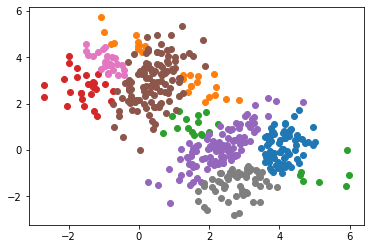

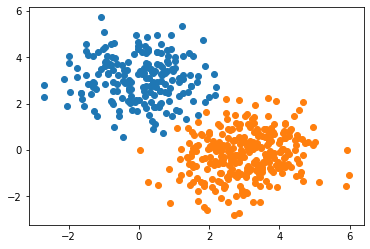

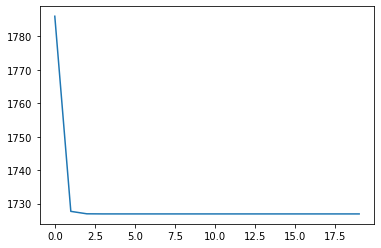

In [223]:
#print_EM(get_xeasy())
proven_EM(get_xeasy())

1233
408
Cluster centroids (mu):  [[-0.10044322  1.97314698]
 [ 2.08440653  0.12438056]]
Cluster Covariance (sigma): [[[ 1.70416771  0.14864816]
  [ 0.14864816  2.19990434]]

 [[ 0.8625534  -0.03892023]
  [-0.03892023  1.05827857]]]
Third thing: [0.65274165 0.34725835]


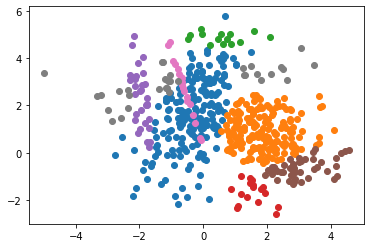

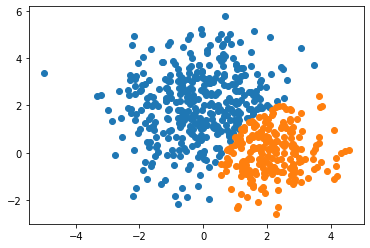

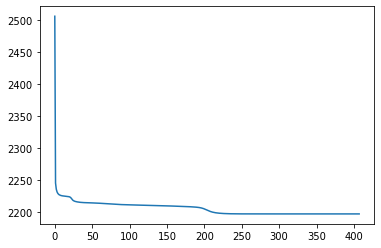

In [224]:
#print_EM(get_x1())
proven_EM(get_x1())

1323
71
Cluster centroids (mu):  [[ 0.1780945  -0.12519419]
 [ 0.01424402 -0.04651448]]
Cluster Covariance (sigma): [[[9.25805934 0.76781914]
  [0.76781914 9.41426884]]

 [[1.06250423 0.06633595]
  [0.06633595 0.88826181]]]
Third thing: [0.48803596 0.51196404]


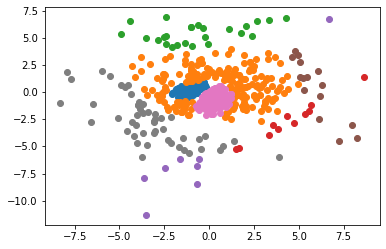

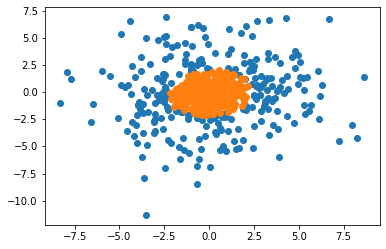

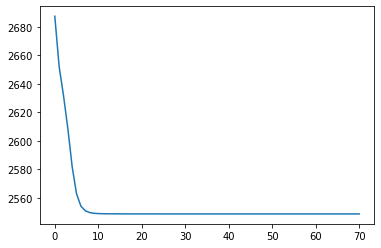

In [225]:
#print_EM(get_x2())
proven_EM(get_x2())